# Internal Tide (only), 1 simulation

To adjust:

- double stratification
- output itide_deltay parameter (forcing y width)
- forcing_itide -> itide_forcing ?

Variable important is `un_std`, `N2` (evolution)

Mode 5 is not well represented with 4km resolution.

watch out sensitity to horizontal width of the itide forcing: it may be comparable to iwave wavelength for high modes

In [1]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt
import crocosi.vmodes as vmd

In [2]:
from dask.distributed import Client, LocalCluster

if True:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:44237,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:39510,Total threads: 7
Dashboard: http://127.0.0.1:60768/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:36296,


## Load data

In [18]:
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
root_path = '/home1/scratch/slgentil/' 


run = "fsturb_t1_r0_a4_4km_0a50j" #: 4 km, itide_h=100m
#run = "fsturb_t2_r0_a4_4km_0a50j" #: 4 km, itide_h=1000m
#run = "fsturb_t3_r0_a4_4km_0a50j" #: 4 km, itide_h=2000m
#run = "fsturb_t1_r0_a4_2km_0a50j" #: 2 km, itide_h=100m
#run = "fsturb_t2_r0_a4_2km_0a50j" #: 2 km, itide_h=1000m
#run = "fsturb_t3_r0_a4_2km_0a50j" #: 2 km, itide_h=2000m

r = pp.Run(root_path+run, outputs=["sec"], verbose=1)
r['sec'] = r['sec'].assign_coords(time=r['sec'].time_counter)

pout = r.params_output

Analysing directory /home1/scratch/slgentil/fsturb_t1_r0_a4_4km_0a50j
Found 1 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / sec
Grid size: (L ,M, N) = (18, 722, 50)


In [19]:
# specific to 2D run ...
def process_dim(da):
    rdict = {}
    for d, d_new in {"y_rhoy": "y_rho", "y_uy": "y_rho", "y_vy": "y_v"}.items(): 
        if d in da.dims:
            rdict[d] = d_new
    return da.rename(rdict)

ds = r["sec"].isel(x_rho=0)
for v in ds:
    ds[v] = process_dim(ds[v])

ds = ds.rename({v: v.replace("_yz", "") for v in ds})
ds = ds.drop(["x_rho", "x_rhoy", "x_uy", "x_vy", "y_rhoy", "y_uy", "y_vy"])

# rechunk along time for larger runs
y = r["sec"].y_rhoy
resolution = int(float(y[1]-y[0])/1e3)
if resolution==2:
    ds = ds.chunk({"time": 10}) # 2km

In [20]:
for k, v in pout.items():
    print('{}: {}'.format(k,v))

itide_omega: 0.0001454441043
itide_nmode: 2.0
forcing_itide: 1.0
itide_h: 100.0
itide_Az: 0.002
itide_y: 1500000.0
itide_start_time: 0.0
tdiag_omega: 0.0001454441043
relax_dist_south: 1000000.0
relax_L_south: 350000.0
relax_tau_in_south: 1000.0
relax_tau_out_south: 1.0
relax_dist_north: 1000000.0
relax_L_north: 350000.0
relax_tau_in_north: 1000.0
relax_tau_out_north: 1.0
depth: 4000.0
f0: 0.00010313
beta: 0.0
yrbeta: 1440000.0
ini_flag: 1.0
ini_delta_rho: 0.001
ini_H_tcline: 0.15
ini_H_mld: 0.025
ini_H: 4000.0
flag_sponges: 1.0


---

## bulk statistics

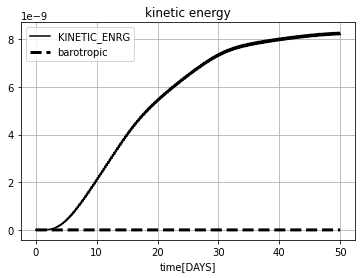

In [21]:
ax = r.stats['KINETIC_ENRG'].plot(color="k", title='kinetic energy')
#r.stats['KINETIC_ENRG'].plot(ax=ax, color='orange')
r.stats['BTKIN_ENRG'].plot(ax=ax, lw=3., color=ax.get_lines()[-1].get_color(), 
                           ls='--', label='barotropic')
ax.grid()
ax.legend()

---

## vertical slices

In [22]:
z_u = r.get_z(zeta=ds.ssh, h=ds.ssh*0+r["depth"])
ds = ds.assign_coords(z_u = z_u)

(<xarray.plot.facetgrid.FacetGrid at 0x2aab43ef21c0>,)

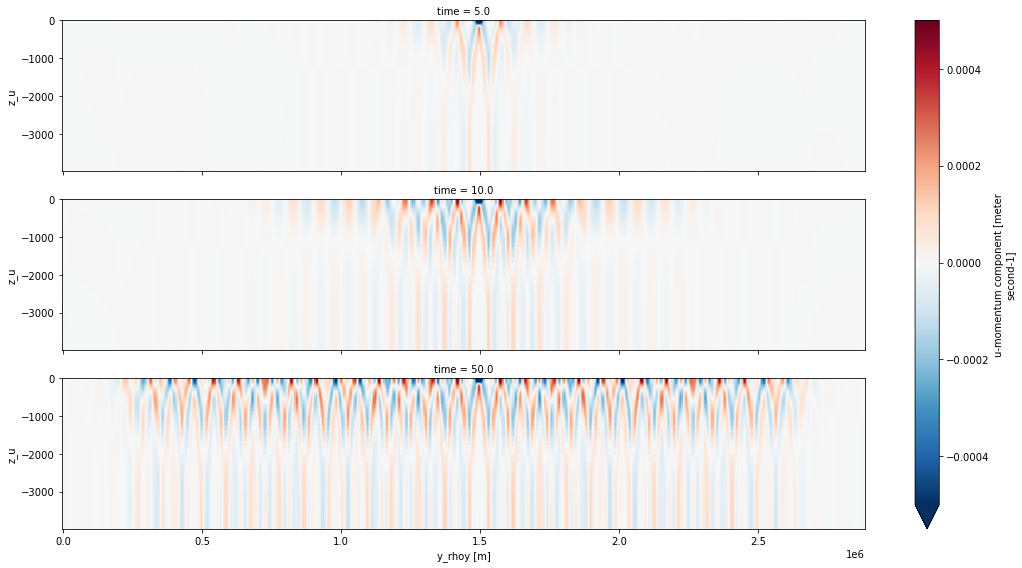

In [23]:
time_slice = [5, 10, 50]

(ds.u
 .sel(time=time_slice)
 .plot(x='y_rho', y='z_u', 
       #xlim=(900*1e3,2000*1e3),
       vmax=5*1e-4,
       figsize=(15,8),
       col='time', col_wrap=1),
)

---

## stratification

In [24]:
_ds = (ds.sel(y_rho=1000e3, method="nearest")
      .persist()
     )
rho = _ds['T']
ssh = _ds['ssh']

z_r = r.get_z(zeta=ssh, h=ssh*0.+r['depth'])
z_w = r.get_z(zeta=ssh, h=ssh*0.+r['depth'], vgrid='w')

N2 = r.get_N2(rho, z_r).rename("N2")

Text(0.5, 1.0, '')

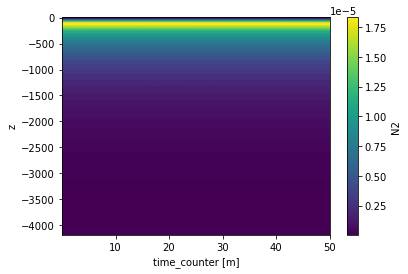

In [25]:
N2.assign_coords(z=z_w.mean("time")).plot(x="time", y="z")
plt.title("")

Text(0.5, 1.0, 'N2 - N2(t=0)')

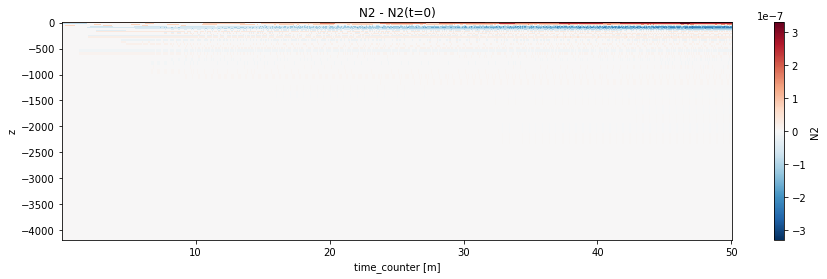

In [26]:
((N2 - N2.isel(time=0))
 .assign_coords(z=z_w.mean("time"))
 .plot(x="time", y="z", figsize=(15,4))
)
plt.title("N2 - N2(t=0)")

---

## vertical mode projections

In [31]:
# time dependent vertical grid
h = r["grid"]["h"].isel(x_rho=0)
ds = ds.assign_coords(h=h)
z_r = r.get_z(zeta=ds["ssh"], h=h, vgrid="r")
z_w = r.get_z(zeta=ds["ssh"], h=h, vgrid="w")

In [32]:
# spatial and temporal mean stratification

dsm = (ds
      .mean(dim=["time","y_rho"])
      .persist()
     )

#ssh = dsm['ssh']
h = r["grid"]["h"].isel(x_rho=0, y_rho=0)

zm_r = r.get_z(zeta=dsm.ssh, h=h)
zm_w = r.get_z(zeta=dsm.ssh, h=h, vgrid='w')


# interpolate first and the compute modes
rho = ds["T"].rename('rho')
rho_i = op.interp2z(zm_r, z_r, rho) # time dependent on mean grid
rho_m = rho_i.mean(["y_rho","time"])

N2 = r.get_N2(rho_m, zm_r)

In [33]:
vm = vmd.Vmodes(r['xgrid'], zm_r, zm_w, N2, 10,
                persist=True)

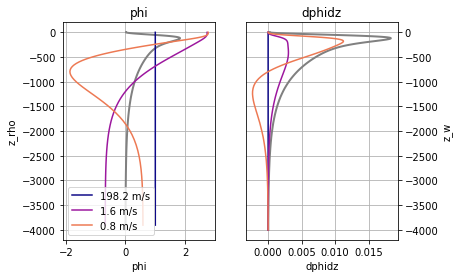

In [34]:
vm.plot()

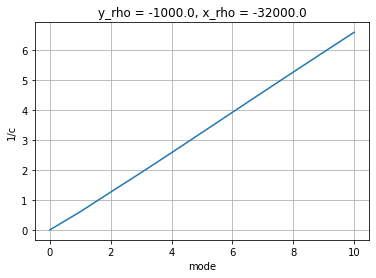

In [19]:
(1/vm["c"]).rename("1/c").plot()
plt.grid()

## project

Wavelength:

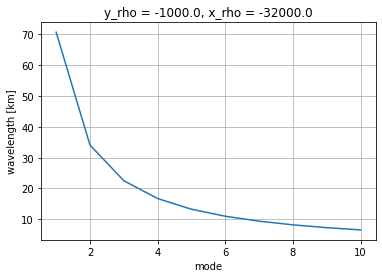

In [20]:
T = 2*np.pi/pout["itide_omega"]
fig, ax = plt.subplots(1,1)
(T*vm["c"][1:]/1e3).rename("wavelength [km]").plot(ax=ax)
ax.grid()

Travel time to exit domain:

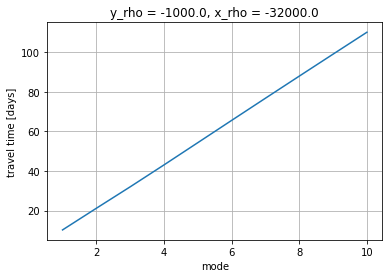

In [21]:
L = float(ds["y_rho"].max())
fig, ax = plt.subplots(1,1)
(L/2/vm["c"][1:]/86400).rename("travel time [days]").plot(ax=ax)
ax.grid()

In [35]:
un = vm.project(ds["u"], "p", z=z_r).persist()

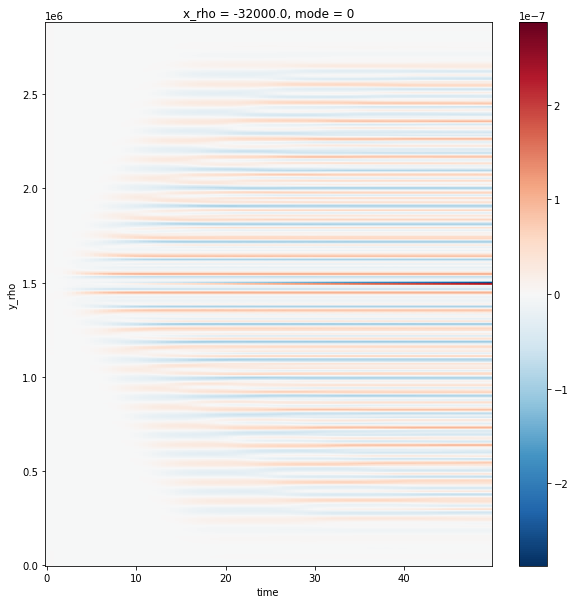

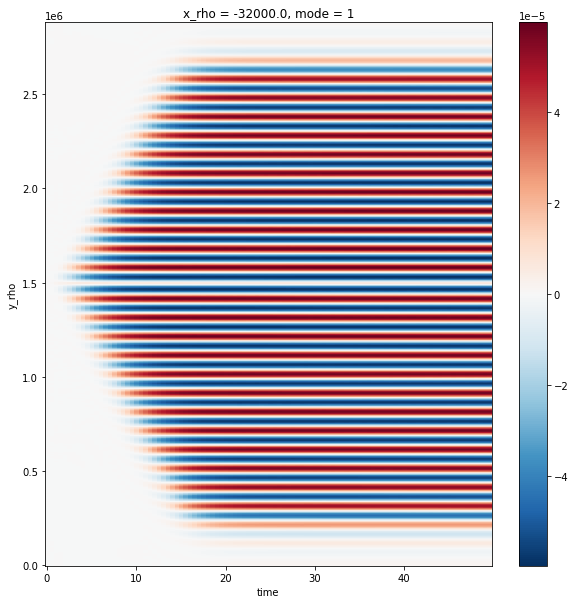

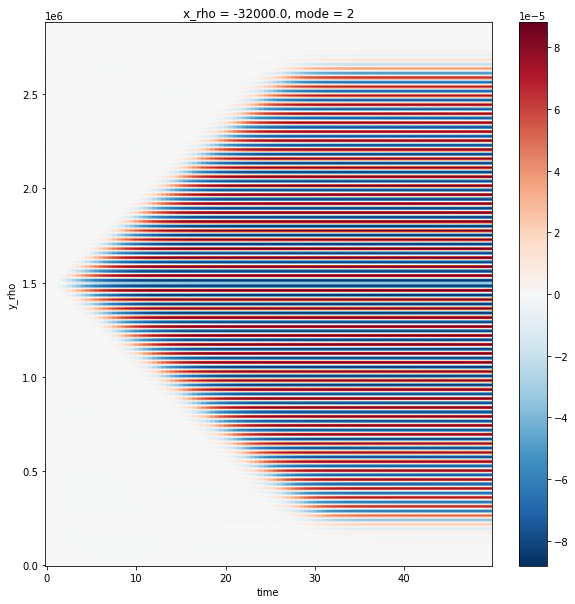

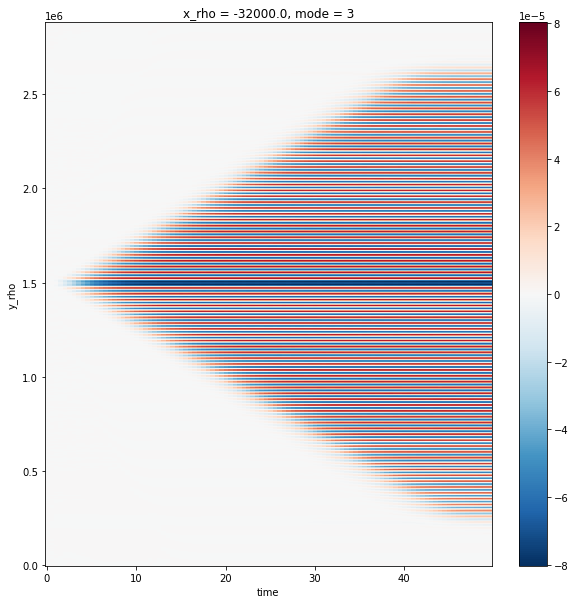

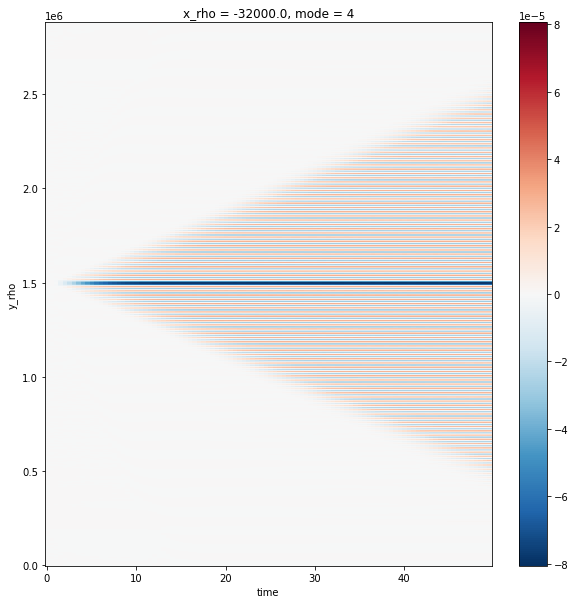

In [36]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    un.sel(mode=m).isel(time=slice(0,None,12)).plot(ax=ax, x="time", y="y_rho")

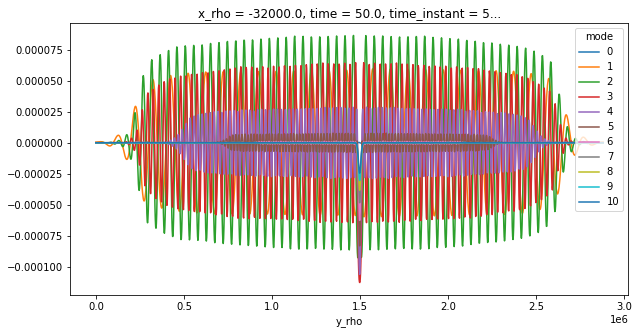

In [37]:
un.isel(time=-1).plot(x="y_rho", hue="mode", figsize=(10,5))

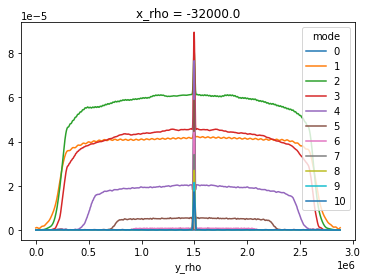

In [38]:
un.sel(time=slice(49,50))[1:].std("time").plot(hue="mode")

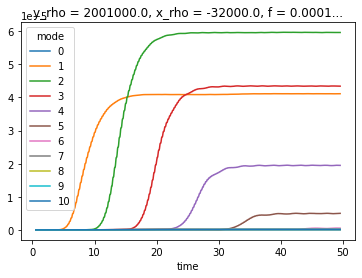

In [39]:
y = 2000e3 # all mode arrive up to here (see diagnostic below)
un_std = un.sel(y_rho=y, method="nearest").rolling(time=24, center=True).std().dropna("time")
un_std.plot(hue="mode")

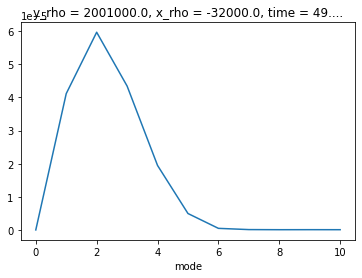

In [40]:
un_std.isel(time=-1).plot()

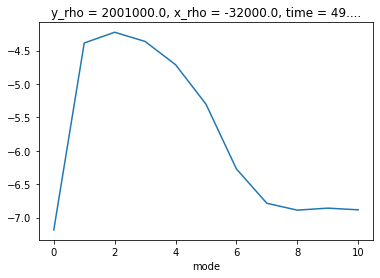

In [41]:
np.log10(un_std.isel(time=-1)).plot()

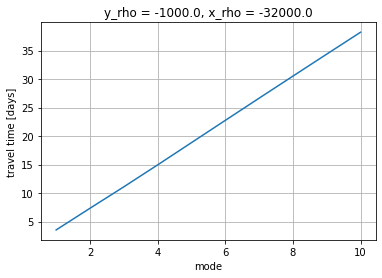

In [42]:
L = (y - pout["itide_y"])

fig, ax = plt.subplots(1,1)
(L/vm["c"][1:]/86400).rename("travel time [days]").plot(ax=ax)
ax.grid()

---

## pressure

In [99]:
# compute pressure on rho grid
p = r.get_p(rho_i - rho_m, zm_w, zr=zm_r)
# should try to use true ROMS integration
# manually had sea level
p = (p + 9.81*ds["ssh"]*r.params_input["rho0"]).rename("p")

# project
pn = vm.project(p, "p")

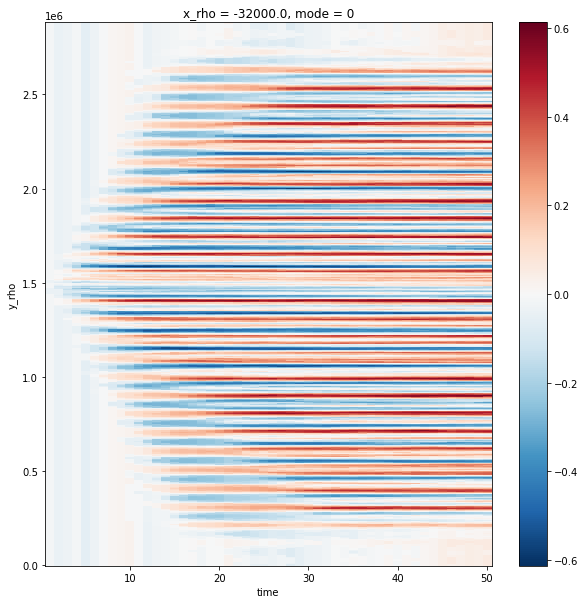

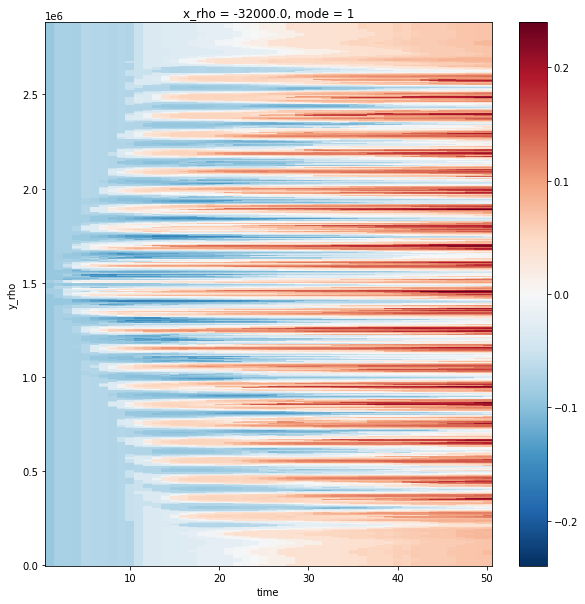

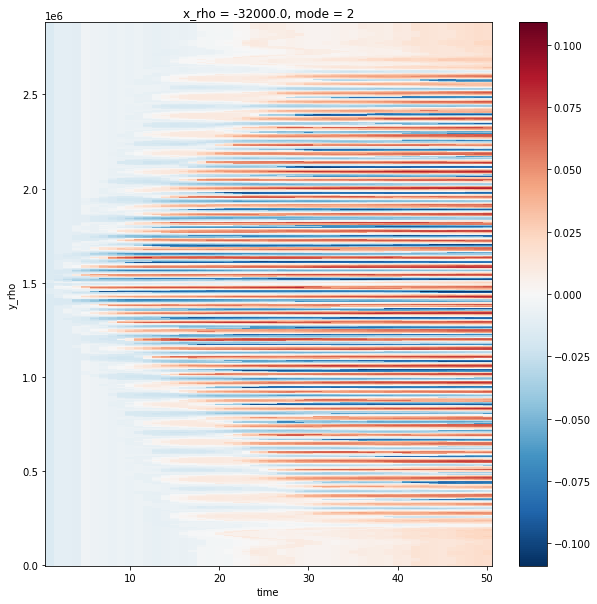

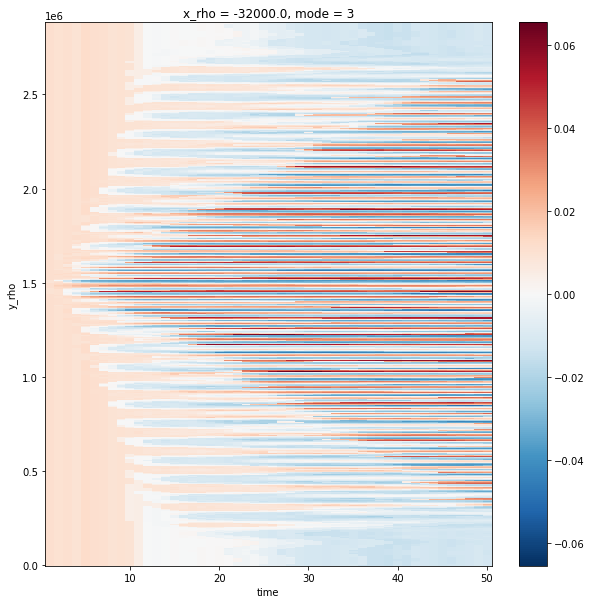

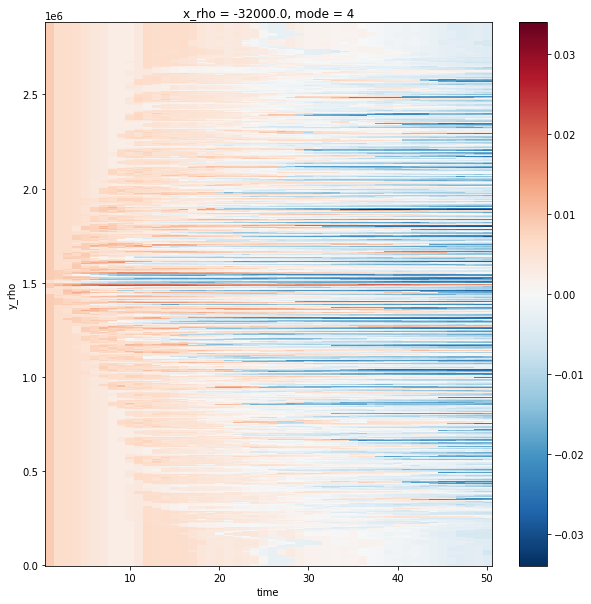

In [101]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    _pn = pn.sel(mode=m)
    #_pn = _pn - _pn.mean("y_rho")
    _pn.plot(ax=ax, x="time", y="y_rho")

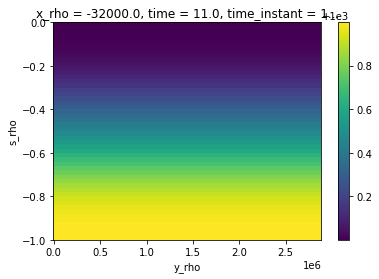

In [102]:
rho_i.isel(time=10).plot(x="y_rho")

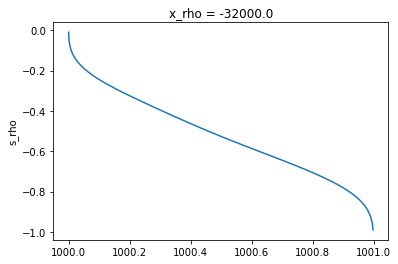

In [103]:
rho_m.plot(y="s_rho")

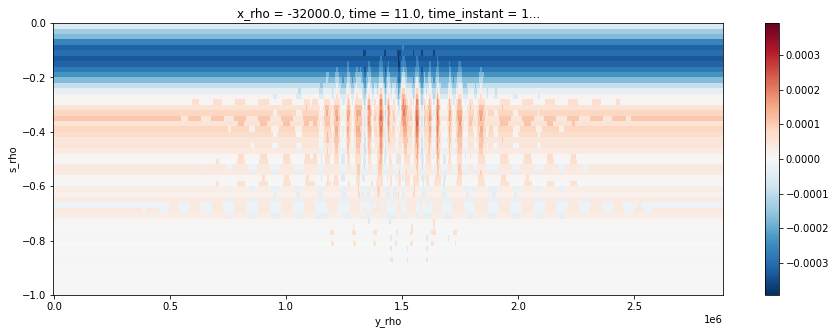

In [83]:
(rho_i - rho_i_mean).isel(time=10).plot(x="y_rho", figsize=(15,5))

In [ ]:
rho = ds["T"].rename('rho')
rho_i = op.interp2z(vm['z_rho'], z_r, rho)

rho_i_mean = rho_i.mean ...

p_i = get_p(vm["z_rho"], rho_i - rho_i_mean)

In [20]:
rho = ds["T"].rename('rho') + r["rho0"]

# compute pressure on rho grid
p_rho = r.get_p(rho, z_w, zr=z_r)

def get_p(grid, rho, zw):
    g = 9.81
    dz = grid.diff(zw, "s")
    p = grid.cumsum(rho*dz, "s", to="outer", boundary="extend")
    #p = grid.cumint(rho, "s", to="outer", boundary="extend")    
    return g*p.rename("p")

# compute pressure on w grid
#p = r.get_p(rho, z_w)
#p = get_p(r.xgrid, rho, z_w)

p = p_rho

# interpolates on mode vertical grid

In [54]:
#p = ds.P
#p = op.interp2z(vm['z_rho'], z_r, p_rho)
p = op.interp2z(vm['z_rho'], z_r, ds.P)

#p = op.interp2z(vm["z_rho"], z_w, p)

p_mean = p.sel(y_rho=slice(.5*1e6, 2.5*1e6)).mean(["y_rho","time"])

In [55]:
9.81*1000*4000

39240000.0

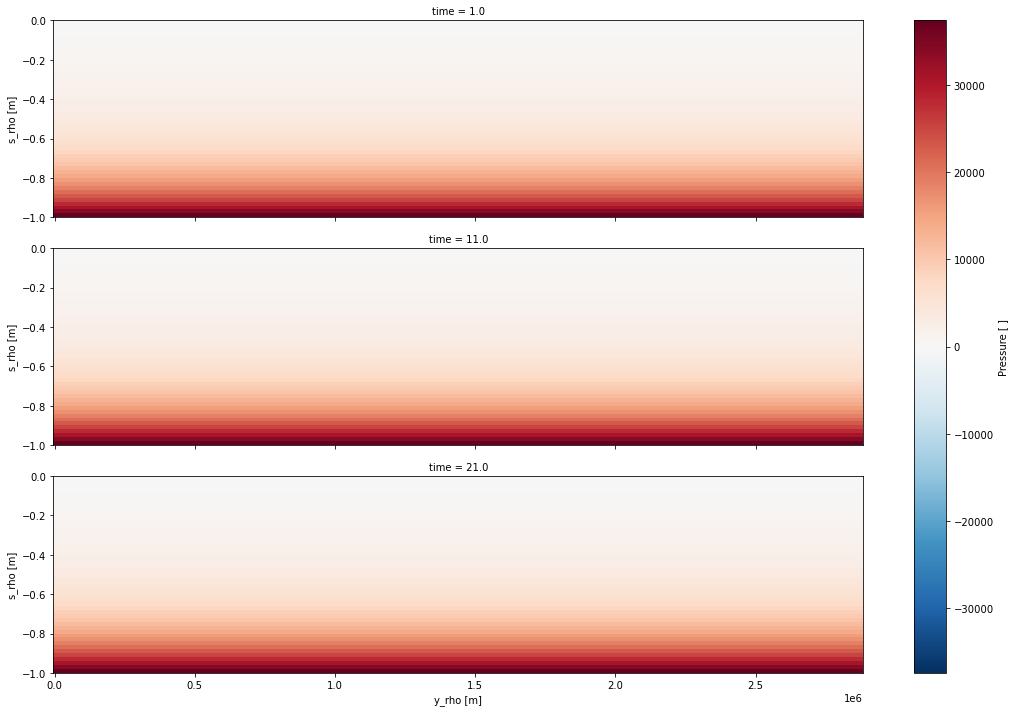

In [56]:
ds.P.isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

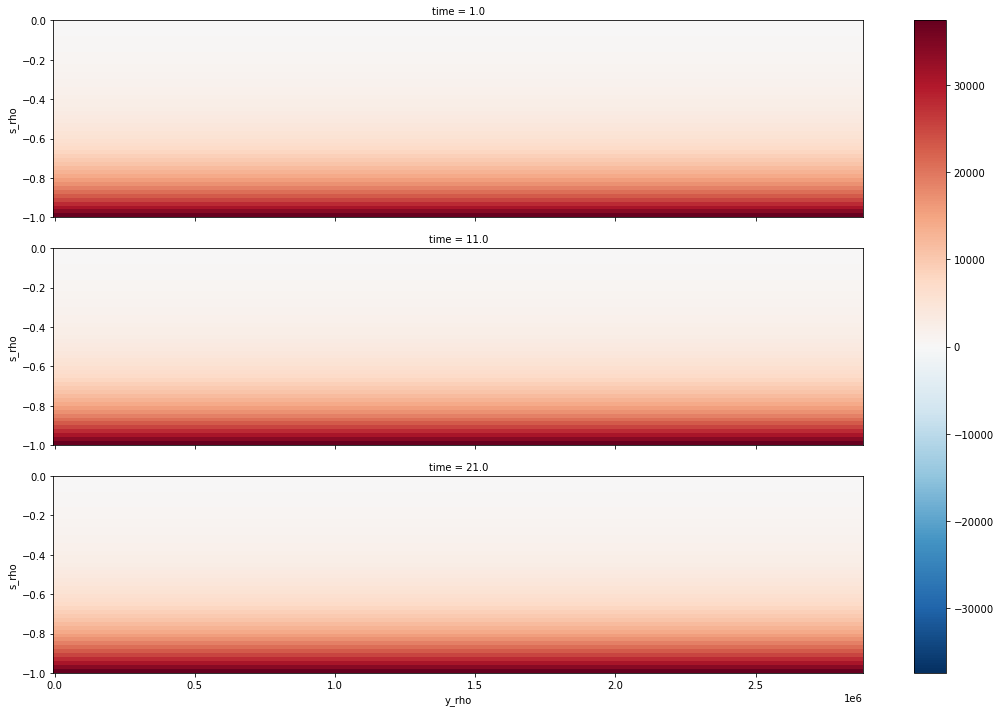

In [57]:
p.isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

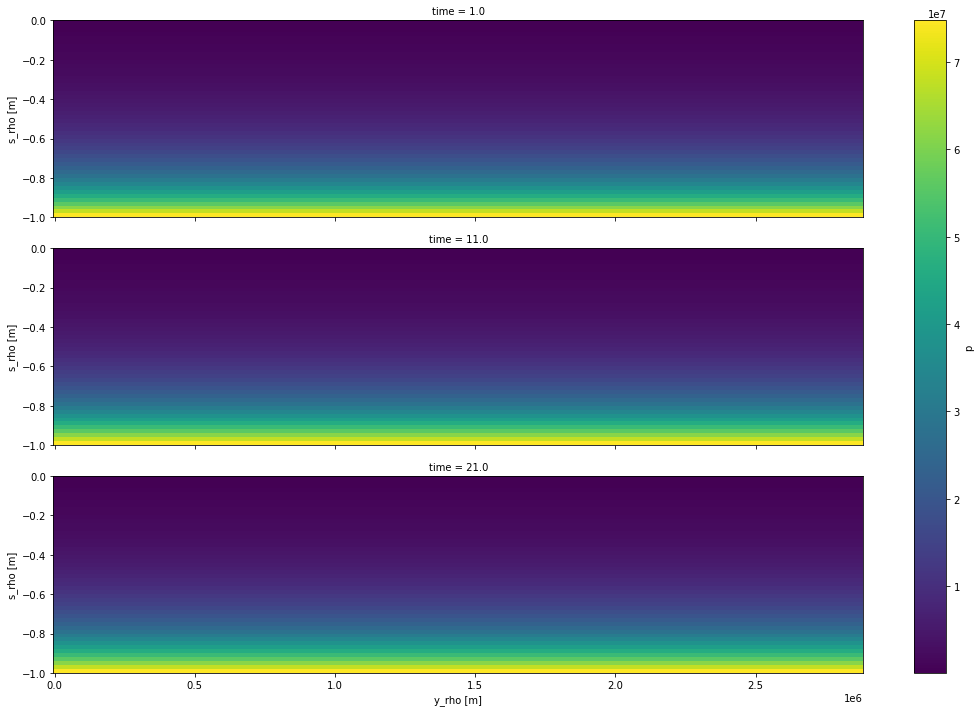

In [22]:
p_rho.isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

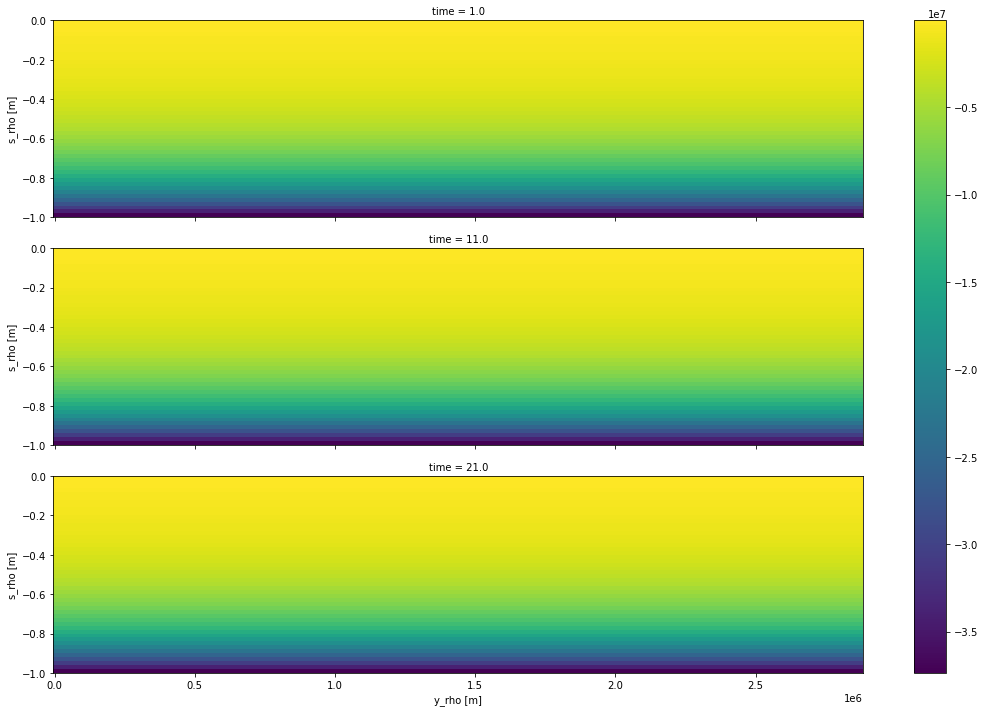

In [23]:
(ds.P*1e3-p_rho).isel(time=slice(0,30,10)).plot(x="y_rho", col="time", col_wrap=1, figsize=(15,10))

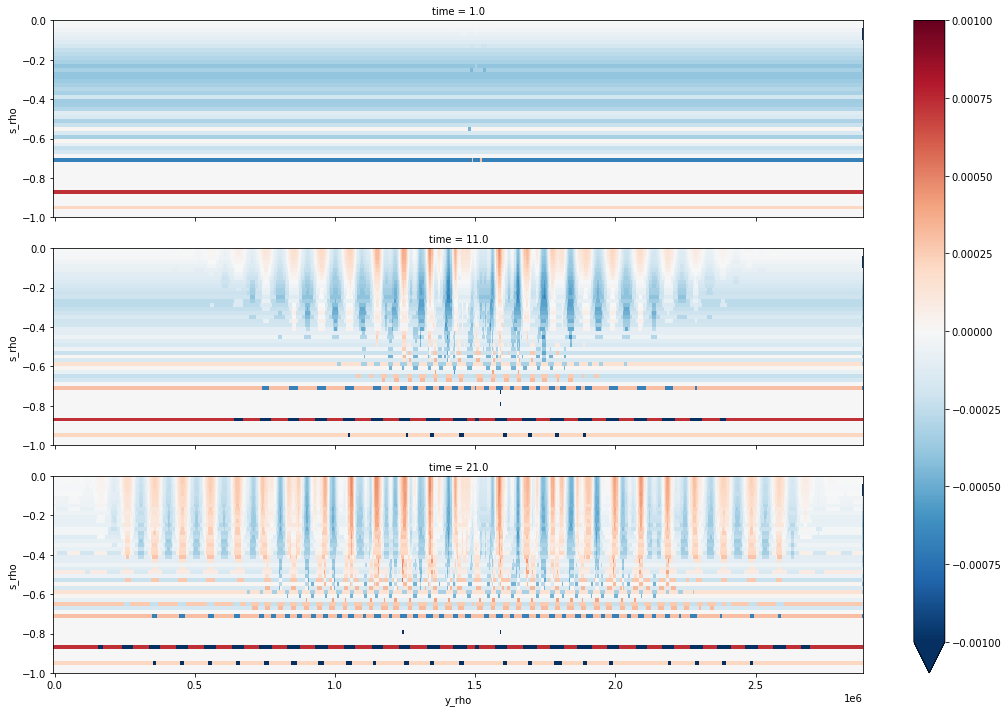

In [58]:
(p-p_mean).isel(time=slice(0,30,10)).plot(x="y_rho", col="time", vmax=.001, col_wrap=1, figsize=(15,10))

In [85]:
# project, data is already on vmode vertical grid
#pn = vm.project(p - p_mean, "p")
pn = vm.project(p_rho, "p")
# abs(ds_depth['z_rho'] - vmodes['z_rho']).max().compute() # 0

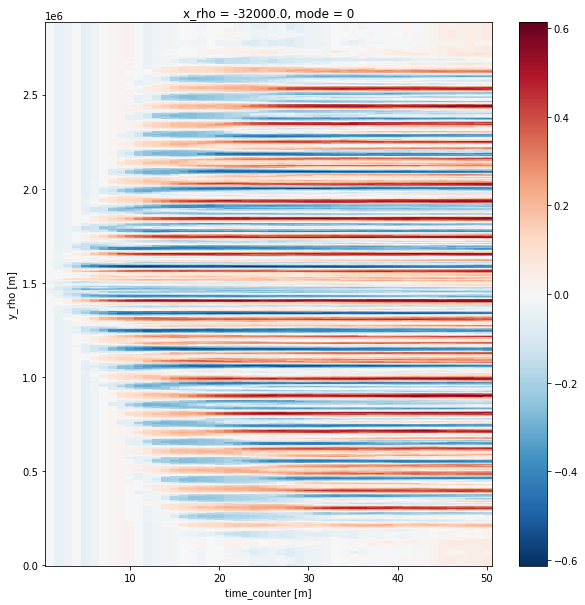

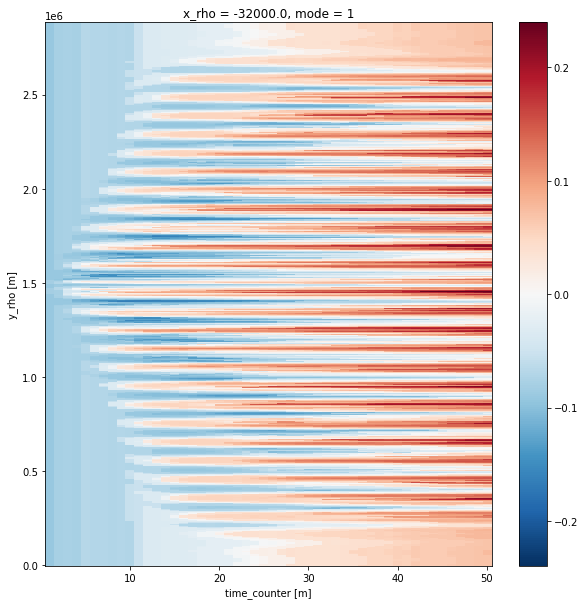

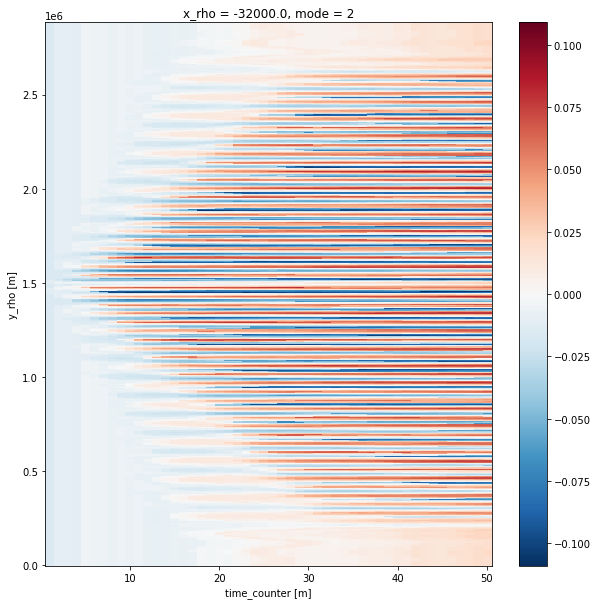

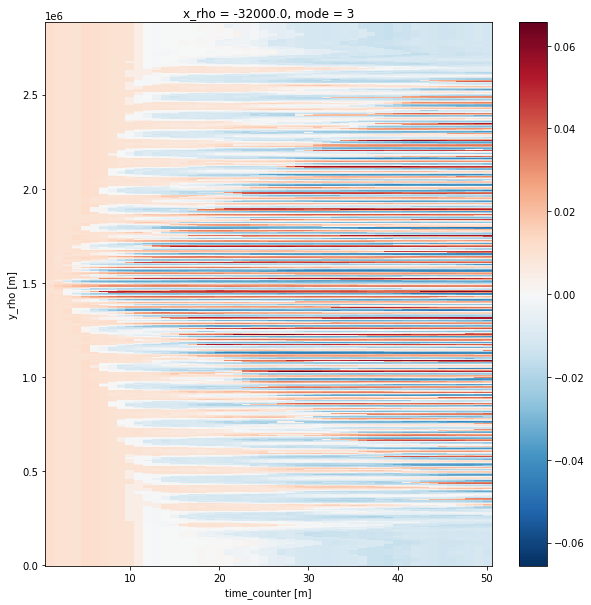

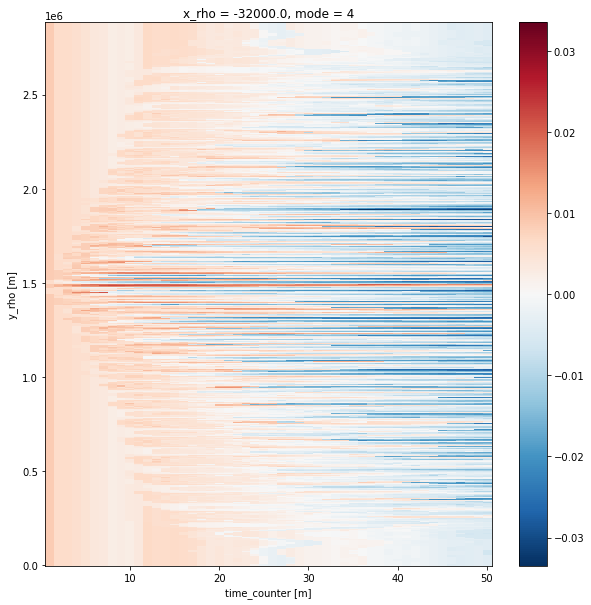

In [88]:
for m in range(5):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    pn.sel(mode=m).plot(ax=ax, x="time", y="y_rho")

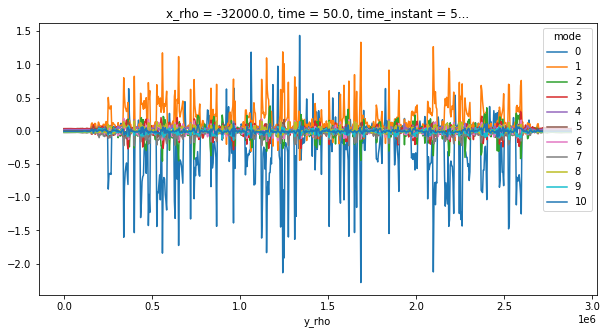

In [17]:
pn.isel(time=-1).plot(x="y_rho", hue="mode", figsize=(10,5))

---

In [ ]:
cluster.close()